# **Simple GLM & Random Forest Model**

This code predicts the outcome (in percentage) of how likely team 1 will win against team 2 for all 68 teams participating in the 2019 NCAA tournamet. All data is from the Google Cloud & NCAA® ML Competition 2019-Men's (https://www.kaggle.com/c/mens-machine-learning-competition-2019). 

### *Variables*
For each NCAA tournament match after 2013, I predict the final result based on the following variables: <br>
(The variables are based on that season's data and information)
* *TeamConferences.csv*: each team's conference name, difference in conference? (1,0), conference code (concatenation of two conference), 
* *NCAATourneySeed.csv*: each team's region, difference in region? (1,0), region code (concatenation of two regions), each team's seed (and difference in seed),
* *MasseyOrdinals_thru_2019_day_128.csv*: each team's rank (and their difference), 
* *RegularSeasonCompactResults.csv*: each team's regular season's win rate (and their difference), each team's average of difference in points from regular season (and their difference)

### *Model *
I used caret package to build 2 models based on GLM and randomForest. Then, I submitted two separate predictions based on the 2 different models.


In [ ]:
library(dplyr)
library(tidyr)
library(Metrics)
library(caret)
library(randomForest)
library(xlsx)

options(warn=-1)

In [2]:
########## GET DATA ##########

teams <- read.csv("../input/stage2datafiles/Teams.csv", stringsAsFactors = FALSE)
seeds <- read.csv("../input/stage2datafiles/NCAATourneySeeds.csv", stringsAsFactors = FALSE)
tourney <- read.csv("../input/stage2datafiles/NCAATourneyCompactResults.csv", stringsAsFactors = FALSE)
regular <- read.csv("../input/stage2datafiles/RegularSeasonCompactResults.csv", stringsAsFactors = FALSE)
rank <- read.csv("../input/masseyordinals_thru_2019_day_128/MasseyOrdinals_thru_2019_day_128.csv", stringsAsFactors = FALSE)
conference <- read.csv("../input/stage2datafiles/TeamConferences.csv", stringsAsFactors = FALSE)
Stage1 <- read.csv("../input/SampleSubmissionStage1.csv", stringsAsFactors = FALSE) %>% 
  select(ID) %>% 
  separate(ID, sep = "_", into = c("Season", "Team1", "Team2"), convert = TRUE)
Stage2 <- read.csv("../input/SampleSubmissionStage2.csv", stringsAsFactors = FALSE) %>% 
  select(ID) %>% 
  separate(ID, sep = "_", into = c("Season", "Team1", "Team2"), convert = TRUE)

## PRE-PROCESS & CLEAN DATA

In [3]:
Season_Year <- 2003 #Only use training data from this date

 ### Clean rank: Calculate average rank by Season 

In [4]:
rank_group <- rank[rank$Season >= Season_Year,c("Season","TeamID","OrdinalRank")] %>%
  group_by(Season,TeamID) %>%
  summarize(rank = mean(OrdinalRank))
head(rank_group)

Season,TeamID,rank
2003,1102,144.2875
2003,1103,182.2050
2003,1104,27.6555
2003,1105,305.3775
2003,1106,243.2650
2003,1107,291.9875


 ### Clean seed: Calculate seed by Season

In [5]:
seeds$region <- substring(seeds$Seed,1,1)
seeds$Seed_num <- as.numeric(substring(seeds$Seed,2,3))
seeds <- seeds[seeds$Season >= Season_Year,c("Season","TeamID","region","Seed_num")]
head(seeds)


,Season,TeamID,region,Seed_num
1155,2003,1328,W,1
1156,2003,1448,W,2
1157,2003,1393,W,3
1158,2003,1257,W,4
1159,2003,1280,W,5
1160,2003,1329,W,6


### Clean regular: Calculate average score difference and win rate by year 

In [6]:
# Score difference
regular$Wdiff <- regular$WScore - regular$LScore
regular$Ldiff <- regular$LScore - regular$WScore
regular_W <- regular[regular$Season >= Season_Year,c("Season","WTeamID","Wdiff")] 
regular_L <- regular[regular$Season >= Season_Year,c("Season","LTeamID","Ldiff")]

# Get Win & Loss counts
regular_W_count <- regular_W %>%
  group_by(Season,WTeamID) %>%
  summarize(Wcount = n())
regular_L_count <- regular_L %>%
group_by(Season,LTeamID) %>%
  summarize(Lcount = n())
colnames(regular_W_count)[2] <- "TeamID"
colnames(regular_L_count)[2] <- "TeamID"

# Get average score difference
colnames(regular_W) <- c("Season","TeamID","diff") 
colnames(regular_L) <- c("Season","TeamID","diff")
regular_group <- rbind(regular_W,regular_L)
regular_group <- regular_group %>%
  group_by(Season,TeamID) %>%
  summarize(scorediff = mean(diff))
regular_group <- left_join(regular_group,regular_W_count,by=c("Season","TeamID"))
regular_group <- left_join(regular_group,regular_L_count,by=c("Season","TeamID"))
regular_group$W_rate <- regular_group$Wcount/(regular_group$Wcount+regular_group$Lcount)
regular_group <- regular_group[,c("Season","TeamID","scorediff","W_rate")]
head(regular_group)

Season,TeamID,scorediff,W_rate
2003,1102,0.2500000,0.4285714
2003,1103,0.6296296,0.4814815
2003,1104,4.2857143,0.6071429
2003,1105,-4.8846154,0.2692308
2003,1106,-0.1428571,0.4642857
2003,1107,-9.7857143,0.2500000


### Clean NCAA tourney table and join variables

In [7]:
# Clean tourney to create train 
# (Duplicate table for both win and loss results then combine them)
df <- tourney[tourney$Season >= Season_Year,c("Season","WTeamID","LTeamID")]
df_W <- df
df_L <- df[,c(1,3,2)]
colnames(df_W) <- c("Season","Team1","Team2")
colnames(df_L) <- c("Season","Team1","Team2")
df_W$result <- 1
df_L$result <- 0
train <- rbind(df_W,df_L)

# Combine train with Stage1/2 submission
train$type = "train"
stage1_temp <- Stage1
stage1_temp$result <- 0
stage1_temp$type = "stage1"
stage2_temp <- Stage2
stage2_temp$result <- 0
stage2_temp$type = "stage2"
data <- rbind(train,stage1_temp,stage2_temp)

# Join - conference
data <- left_join(data,conference,by=c("Season"="Season","Team1"="TeamID"))
colnames(data)[length(names(data))] <- "conf1"
data <- left_join(data,conference,by=c("Season"="Season","Team2"="TeamID"))
colnames(data)[length(names(data))] <- "conf2"
data$confdiff <- ifelse(data$conf1 == data$conf2, 0 ,1)
data$confcode <- paste(data$conf1,data$conf2,sep="")

# Join - rank
data <- left_join(data,rank_group,by=c("Season"="Season","Team1"="TeamID"))
colnames(data)[length(names(data))] <- "rank1"
data <- left_join(data,rank_group,by=c("Season"="Season","Team2"="TeamID"))
colnames(data)[length(names(data))]  <- "rank2"
data$rankdiff <- data$rank1 - data$rank2

# Join - seed
data <- left_join(data,seeds,by=c("Season"="Season","Team1"="TeamID"))
colnames(data)[length(names(data))-1] <- "region1"
colnames(data)[length(names(data))] <- "seed1"
data <- left_join(data,seeds,by=c("Season"="Season","Team2"="TeamID"))
colnames(data)[length(names(data))-1] <- "region2"
colnames(data)[length(names(data))] <- "seed2"
data$seeddiff <- data$seed1 - data$seed2
data$regiondiff <- ifelse(data$region1 == data$region2, 0 ,1)
data$regioncode <- paste(data$region1,data$region2,sep="")

# Join - regular season records
data <- left_join(data,regular_group,by=c("Season"="Season","Team1"="TeamID"))
colnames(data)[length(names(data))-1] <- "scorediff1"
colnames(data)[length(names(data))] <- "W_rate1"
data <- left_join(data,regular_group,by=c("Season"="Season","Team2"="TeamID"))
colnames(data)[length(names(data))-1] <- "scorediff2"
colnames(data)[length(names(data))] <- "W_rate2"
data$scorediffdiff <- data$scorediff1 - data$scorediff2
data$W_ratediff <- data$W_rate1 - data$W_rate2

head(data)
summary(data)

Season,Team1,Team2,result,type,conf1,conf2,confdiff,confcode,rank1,⋯,seed2,seeddiff,regiondiff,regioncode,scorediff1,W_rate1,scorediff2,W_rate2,scorediffdiff,W_ratediff
2003,1421,1411,1,train,big_south,swac,1,big_southswac,241.370000,⋯,16,0,0,XX,-7.241379,0.4482759,1.966667,0.6000000,-9.2080460,-0.15172414
2003,1112,1436,1,train,pac_ten,aec,1,pac_tenaec,3.676744,⋯,16,-15,0,ZZ,14.964286,0.8928571,4.655172,0.6551724,10.3091133,0.23768473
2003,1113,1272,1,train,pac_ten,cusa,1,pac_tencusa,40.892500,⋯,7,3,0,ZZ,6.793103,0.6206897,8.689655,0.7931034,-1.8965517,-0.17241379
2003,1141,1166,1,train,mac,mvc,1,macmvc,75.095000,⋯,6,5,0,ZZ,6.103448,0.7931034,14.909091,0.8787879,-8.8056426,-0.08568443
2003,1143,1301,1,train,pac_ten,acc,1,pac_tenacc,40.748184,⋯,9,-1,0,WW,4.724138,0.7241379,4.400000,0.6000000,0.3241379,0.12413793
2003,1163,1140,1,train,big_east,mwc,1,big_eastmwc,31.087264,⋯,12,-7,0,XX,8.633333,0.7000000,8.774194,0.7419355,-0.1408602,-0.04193548


     Season         Team1          Team2          result       
 Min.   :2003   Min.   :1101   Min.   :1102   Min.   :0.00000  
 1st Qu.:2015   1st Qu.:1163   1st Qu.:1285   1st Qu.:0.00000  
 Median :2016   Median :1235   Median :1371   Median :0.00000  
 Mean   :2016   Mean   :1243   Mean   :1350   Mean   :0.06648  
 3rd Qu.:2018   3rd Qu.:1308   3rd Qu.:1433   3rd Qu.:0.00000  
 Max.   :2019   Max.   :1463   Max.   :1463   Max.   :1.00000  
                                                               
     type              conf1              conf2              confdiff     
 Length:15764       Length:15764       Length:15764       Min.   :0.0000  
 Class :character   Class :character   Class :character   1st Qu.:1.0000  
 Mode  :character   Mode  :character   Mode  :character   Median :1.0000  
                                                          Mean   :0.9584  
                                                          3rd Qu.:1.0000  
                                      

### Create Train Table for Modeling

In [8]:
# Replace Categorical to Numerical
data$region1 <- as.numeric(factor(data$region1))
data$region2 <- as.numeric(factor(data$region2))
data$regioncode <- as.numeric(factor(data$regioncode))
data$conf1 <- as.numeric(factor(data$conf1))
data$conf2 <- as.numeric(factor(data$conf2))
data$confcode <- as.numeric(factor(data$confcode))

# Split train, Stage1/2 back out
trainData_raw <- data[data$type == "train",]
Stage1Data_raw <- data[data$type == "stage1",]
Stage2Data_raw <- data[data$type == "stage2",]

# Replace all NA with medianImpute - using caret
pp <- preProcess(trainData_raw, method = "medianImpute")
trainData_raw <- predict(pp, newdata = trainData_raw)
pp <- preProcess(Stage1Data_raw, method = "medianImpute")
Stage1Data_raw <- predict(pp, newdata = Stage1Data_raw)
pp <- preProcess(Stage2Data_raw, method = "medianImpute")
Stage2Data_raw <- predict(pp, newdata = Stage2Data_raw)

## TRAIN SET & MODELING
I used caret for both GLM and randomForest

In [9]:
# choose variables
variables <- c("rank1","rank2",
               "rankdiff",
               "region1", "seed1","region2","seed2",
               "conf1", "conf2","confdiff","confcode",              
               "seeddiff","regiondiff","regioncode",
               "scorediff1","W_rate1","scorediff2","W_rate2",
               "scorediffdiff","W_ratediff")

trainresult <- as.factor(trainData_raw$result)
levels(trainresult) <- c("L","W")
trainData <- trainData_raw[variables]
Stage1Data <- Stage1Data_raw[variables]
Stage2Data <- Stage2Data_raw[variables]

### GLM

In [10]:
# Model Train
cctrl1 <- trainControl(method="cv", number=10, returnResamp="all",
                       classProbs=TRUE, summaryFunction=twoClassSummary)
set.seed(929)
glm_cv <- train(trainData, trainresult, method = "glm", 
                             trControl = cctrl1, metric = "ROC")

# Predict on Test & Check Accuracy
trainData_raw$pred_glm <- predict(glm_cv, trainData, type="prob")$W
logLoss(trainData_raw$result, trainData_raw$pred_glm)

[1] 0.541786

### randomForest

[1] 0.1565983

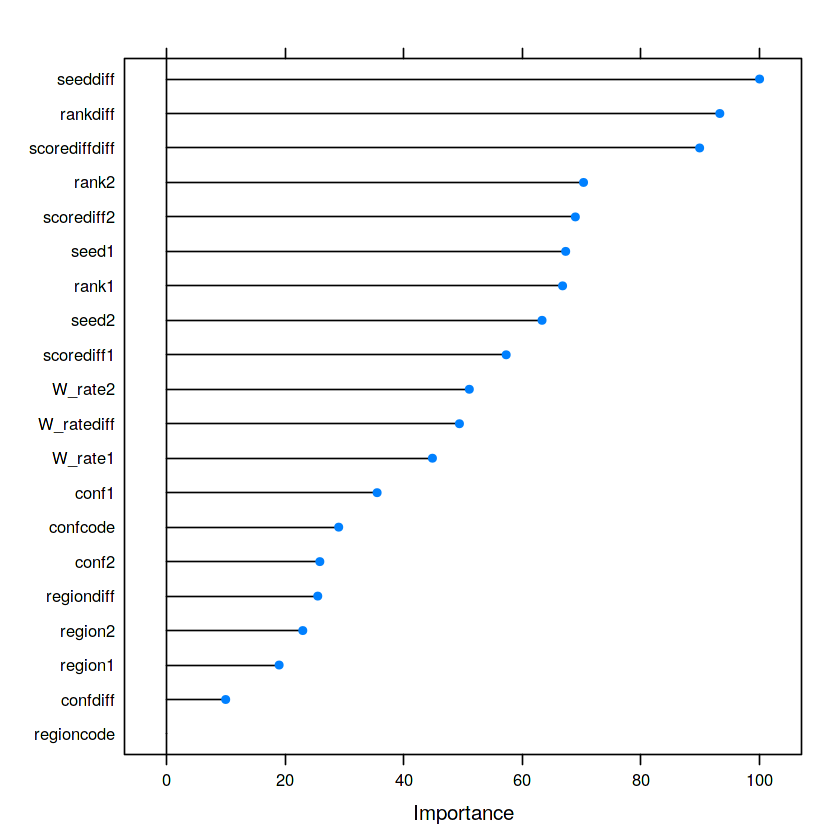

In [11]:
# Model Train
cctrl1 <- trainControl(method="cv", number=5, returnResamp="all",
                       classProbs=TRUE, summaryFunction=twoClassSummary)
set.seed(929)
rf_cv <- train(trainData, trainresult, method = "rf", 
                trControl = cctrl1, metric = "ROC", importance = TRUE,
               ntree = 100, tuneGrid = expand.grid(.mtry=5))
plot(varImp(rf_cv))

# Predict on Test & Check Accuracy
trainData_raw$pred_rf <- predict(rf_cv, trainData, type="prob")$W
logLoss(trainData_raw$result, trainData_raw$pred_rf)

## PREDICTING AND EXPORT

In [12]:
# GLM
Stage1$pred <- predict(glm_cv, Stage1Data, type="prob")$W
Stage2$pred <- predict(glm_cv, Stage2Data, type="prob")$W

# RF 
Stage1$pred <- predict(rf_cv, Stage1Data, type="prob")$W
Stage2$pred <- predict(rf_cv, Stage2Data, type="prob")$W
submitR1 <- Stage2 %>% 
  select(Season, Team1, Team2, pred) %>%
  unite("ID", Season, Team1, Team2, sep = "_") %>%
  write.csv("../stage2_rf.csv", row.names = FALSE)

## MATCH TEAM IDTO TEAM NAMES
This was done for my own manual bracket creation

In [13]:
Stage2$pred_rf <- predict(rf_cv, Stage2Data)
teams <- teams[,c("TeamID","TeamName")]
Stage2 <- left_join(Stage2,teams,by=c("Team1"="TeamID"))
colnames(Stage2)[length(names(Stage2))] <- "Team1_name"
Stage2 <- left_join(Stage2,teams,by=c("Team2"="TeamID"))
colnames(Stage2)[length(names(Stage2))] <- "Team2_name"
#write.xlsx(Stage2, "../Predictions.xlsx", row.names = FALSE)